In [595]:
# %matplotlib inline
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from random import Random
from sklearn.model_selection import KFold, cross_val_predict
# from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline, BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
# from sklearn.decomposition import PCA
# from scipy.stats import percentileofscore
from scipy.stats import hmean

In [596]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [606]:
def load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    
    y = np.log(train['SalePrice'].values)
    ids_submission = test['Id'].values
    
    combined = train.append(test, ignore_index=True).drop(['SalePrice'], axis=1)
    
    ordered_levels = {
        "Alley": ["Grvl", "Pave"],
        "BsmtCond": ["Po", "Fa", "TA", "Gd"],
        "BsmtExposure": ["No", "Mn", "Av", "Gd"],
        "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
        "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
        "BsmtQual": ["Fa", "TA", "Gd", "Ex"],
        "CentralAir": ["N", "Y"],
        "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
        "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
        "ExterQual": ["Fa", "TA", "Gd", "Ex"],
        "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
        "FireplaceQu": ["Po", "Fa", "TA", "Gd", "Ex"],
        'Functional': ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
        "GarageCond": ["Po", "Fa", "TA", "Gd", "Ex"],
        "GarageFinish": ["Unf", "RFn", "Fin"],
        "GarageQual": ["Po", "Fa", "TA", "Gd", "Ex"],
        "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
        "KitchenQual": ["Fa", "TA", "Gd", "Ex"],
        "LotShape": ["IR3", "IR2", "IR1", "Reg"],
        "PavedDrive": ["N", "P", "Y"],
        "PoolQC": ["Fa", "Gd", "Ex"],
        "Street": ["Grvl", "Pave"],   
        "Utilities": ["NoSeWa", "AllPub"]
    }
    
    for c in combined.columns:
        if combined[c].dtype == 'object':
            if c in ordered_levels:
                combined[c] = combined[c].astype('category', categories = ordered_levels[c], ordered=True)
            else:
                combined[c] = combined[c].astype('category')
                    
    X = combined.iloc[:train.shape[0],:]
    X_submission = combined.iloc[train.shape[0]:,:]
    
    return y, X, X_submission, ids_submission   

y, X, X_submission, ids_submission = load_data()

In [607]:
class ProcessData(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        X.drop(['Id'], axis=1, inplace=True)
        X["HasFireplace"] = 1 - X["FireplaceQu"].isnull() * 1
        X["AttchdGarage"] = (X['GarageType'] == "Attchd") * 1
                
        for c in X.columns:
            if X[c].dtype.name == 'category':
                if X[c].cat.ordered:
                    X[c] = X[c].cat.codes
                    
        return pd.get_dummies(X)

In [703]:
model = make_pipeline(ProcessData(),
                      Imputer(strategy='most_frequent'),
                      GradientBoostingRegressor(random_state=1773,
                                                learning_rate=0.1,
                                                max_depth=4,
                                                max_features=0.7,
                                                min_samples_leaf=1,
                                                n_estimators=250,
                                                subsample=0.75))

In [704]:
def get_oof_preds(model, X, y, X_sub, n_folds=10, n_iter=1, seed=1234):
    preds = np.zeros((np.shape(X)[0], n_iter))
    preds_sub = np.zeros((np.shape(X_sub)[0], n_iter))
    rng = Random(seed)
    for i in range(n_iter):
        rs = rng.randint(1,9999)
        folds = KFold(n_folds, shuffle=True, random_state=rs)
        preds_sub_j = np.zeros((np.shape(X_sub)[0], n_folds))
        print 'iter: {}'.format(i)
        for j, (train_index, test_index) in enumerate(folds.split(X)):
            X_train = X.iloc[train_index, :]
            X_test = X.iloc[test_index, :]
            y_train = y[train_index]
            model.fit(X_train, y_train)
            preds[test_index, i] = model.predict(X_test)
            preds_sub_j[:,j] = model.predict(X_sub)
        preds_sub[:, i] = hmean(preds_sub_j, axis=1)
    return preds, preds_sub

In [706]:
%%time
oof_preds, bld_preds_sub = get_oof_preds(model, X, y, X_submission, n_folds=20, n_iter=20, seed=1337)

iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
CPU times: user 12min 56s, sys: 1.51 s, total: 12min 58s
Wall time: 12min 58s


In [683]:
%matplotlib inline
import matplotlib.pyplot as plt

In [708]:
cv_scores = np.apply_along_axis(lambda x: rmse(y, x), axis=0, arr=oof_preds)
print 'score:', hmean(cv_scores), np.std(cv_scores)

score: 0.124096394024 0.00216032764525


In [710]:
bld_preds_sub_hmean = hmean(bld_preds_sub, axis=1)
bld_preds_sub_std = np.std(bld_preds_sub, axis=1)

In [711]:
print 'submission'
print 'std (max):', np.max(bld_preds_sub_std)

submission
std (max): 0.0254741396425


In [712]:
oof_preds_hmean = hmean(oof_preds, axis=1)
oof_preds_std = np.std(oof_preds, axis=1)

In [714]:
np.max(oof_preds_std)

0.19015253709481195

In [685]:
#0.118766769276

In [715]:
print 'rmse:', rmse(y, oof_preds_hmean)

rmse: 0.118766769276


In [719]:
max_error_index = np.argmax(np.abs(y - oof_preds_hmean))
print (y - oof_preds_hmean)[max_error_index]
print X['Id'][max_error_index]

-1.14187386892
524


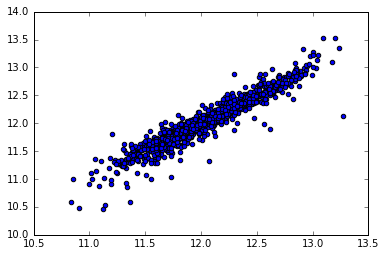

In [718]:
plt.scatter(x=oof_preds_hmean, y=y);

In [729]:
pd.DataFrame({'Id': ids_submission, 'SalePrice': np.exp(bld_preds_sub_hmean)})\
  .to_csv('../ensemble/models/bld_gbm_sub.csv', index=False)

In [727]:
model_output = {'train': list(oof_preds_hmean), 'test': list(bld_preds_sub_hmean)}

In [728]:
import json
with open('../ensemble/models/bld_gbm.json', 'w') as outfile:
    json.dump(model_output, outfile)